Our plan is to use the tournament seeds as a predictor of tournament performance. 
We will train a logistic regressor on the difference in seeding between the two teams playing, and have the result of the game as the desired output

This is inspired by [last years competition][1], where [Jared Cross made a model just based on the team seeds][2].


  [1]: https://www.kaggle.com/c/march-machine-learning-mania-2016
  [2]: https://www.kaggle.com/jaredcross/march-machine-learning-mania-2016/getting-started

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

ImportError: cannot import name '_safe_split'

## Load the training data ##
We are just having a look at the format of the training data to make sure that it looks like we expect

In [2]:
data_dir = '../input/'
df_seeds = pd.read_csv(data_dir + 'TourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'TourneyCompactResults.csv')

In [3]:
df_seeds.head()

Season Seed  Team
0    1985  W01  1207
1    1985  W02  1210
2    1985  W03  1228
3    1985  W04  1260
4    1985  W05  1374

In [4]:
df_tour.head()

Season  Daynum  Wteam  Wscore  Lteam  Lscore Wloc  Numot
0    1985     136   1116      63   1234      54    N      0
1    1985     136   1120      59   1345      58    N      0
2    1985     136   1207      68   1250      43    N      0
3    1985     136   1229      58   1425      55    N      0
4    1985     136   1242      49   1325      38    N      0

Let's drop the columns we are not planning on using

In [5]:
df_tour.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)

Get the seeds as integers

In [6]:
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

## Merge seed for each team ##
We want the seeds in the same DataFrame as the game results

In [7]:
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

In [8]:
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'Wteam'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed

## Make a new DF with just the wins and losses ##

In [9]:
df_wins = pd.DataFrame()
df_wins['seed_diff'] = df_concat['seed_diff']
df_wins['result'] = 1

df_losses = pd.DataFrame()
df_losses['seed_diff'] = -df_concat['seed_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))

In [10]:
X_train = df_for_predictions.seed_diff.values.reshape(-1,1)
y_train = df_for_predictions.result.values
X_train, y_train = shuffle(X_train, y_train)

## Train the estimator ##
We use logistic regression, so we have to set a `C` value. We can just try a bunch of different values and then choose the best one.

In [11]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5539, with best C: 0.01


## Examine the classifier predictions ##

In [12]:
X = np.arange(-16, 16).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

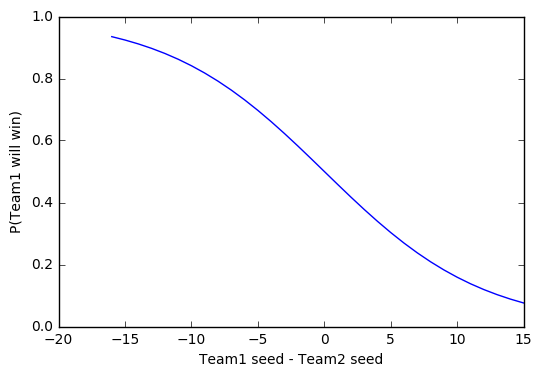

In [13]:
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

This looks like we would expect. We are predicting the probability of team1 winning. If that team has a lower seed than team2, there is a high probability of team1 winning.

## Get the test data ##

In [14]:
df_sample_sub = pd.read_csv(data_dir + 'sample_submission.csv')
n_test_games = len(df_sample_sub)

In [15]:
def get_year_t1_t2(id):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in id.split('_'))

We loop over each row in the `sample_submission.csv` file. For each row, we extract the year and the teams playing. 
We then look up the seeds for each of those teams *in that season*. 
Finally we add the seed difference to an array.

In [16]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.id)
    # There absolutely must be a better way of doing this!
    t1_seed = df_seeds[(df_seeds.Team == t1) & (df_seeds.Season == year)].n_seed.values[0]
    t2_seed = df_seeds[(df_seeds.Team == t2) & (df_seeds.Season == year)].n_seed.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

## Make the predictions ##

In [17]:
preds = clf.predict_proba(X_test)[:,1]

In [18]:
clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.pred = clipped_preds
df_sample_sub.head()

id      pred
0  2013_1103_1107  0.622432
1  2013_1103_1112  0.268988
2  2013_1103_1125  0.458439
3  2013_1103_1129  0.541561
4  2013_1103_1137  0.458439

In [19]:
df_sample_sub.to_csv('logreg_on_seed.csv', index=False)